In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder

In [2]:
df = pd.read_csv("../data/Train.csv")

In [3]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
df.dropna(inplace=True)

In [5]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C


In [6]:
df["Segmentation"].unique()

array(['D', 'B', 'C', 'A'], dtype=object)

In [7]:
class RemoveFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns_1=["ID"]):
        self.columns_1 = columns_1

    def fit(self, df: pd.DataFrame):
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        if (set(self.columns_1).issubset(df.columns)):
            print("1")
            df.drop(self.columns_1, axis = 1, inplace=True)
            return df

        

class Encoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df: pd.DataFrame):
        return self
    def transform(self,df: pd.DataFrame) -> pd.DataFrame:
        df["Gender"] = df["Gender"].map({"Male": 1.0, "Female": 0.0})
        df["Ever_Married"] = df["Ever_Married"].map({"Yes": 1.0, "No": 0.0})
        df["Graduated"] = df["Graduated"].map({"Yes": 1.0, "No": 0.0})
        df["Segmentation"] = df["Segmentation"].map({'D': 0.0, 'B': 1.0, 'C': 2.0, 'A': 3.0})
        return df

class LabelEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, columns_2 = ["Profession", "Spending_Score", "Var_1"]):
        self.columns_2 = columns_2
    def fit(self, df: pd.DataFrame):
        return self
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        lb = OrdinalEncoder()
        df[self.columns_2] = lb.fit_transform(df[self.columns_2])
        return df
        
        

class Normalize(BaseEstimator, TransformerMixin):
    def __init__(self, columns_3 = ["Age", "Work_Experience", "Family_Size"]):
        self.columns_3 = columns_3

    def fit(self, df: pd.DataFrame):
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        sc = StandardScaler()
        df[self.columns_3] = sc.fit_transform(df[self.columns_3])
        return df

class Outliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.th1 = 0.25
        self.th3 = 0.75
        self.features = None

    def fit(self, df: pd.DataFrame):
        self.features = df.columns
        return self

    def outliers_thresholds(self, df, feature, th1, th3):
        Q1 = df[feature].quantile(th1)
        Q3 = df[feature].quantile(th3)
        iqr = Q3 - Q1
        upper_limit = Q3 + 3 * iqr
        lower_limit = Q1 - 3 * iqr
        return upper_limit, lower_limit

    def check_outliers(self, df, feature):
        upper_limit, lower_limit = self.outliers_thresholds(df, feature, th1=self.th1, th3=self.th3)
        if df[(df[feature] > upper_limit) | (df[feature] < lower_limit)].any(axis=None):
            return True
        else:
            return False

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        for feature in self.features:
            if feature != 'Segmentation' and feature != 'ID' and feature in df.columns:
                outliers = self.check_outliers(df, feature)
                upper_limit, lower_limit = self.outliers_thresholds(df, feature, th1=self.th1, th3=self.th3)
                if outliers:
                    if lower_limit < 0:
                        df.loc[(df[feature] > upper_limit), feature] = upper_limit
                    else:
                        df.loc[(df[feature] < lower_limit), feature] = lower_limit
                        df.loc[(df[feature] > upper_limit), feature] = upper_limit
        return df

In [8]:
df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
...,...,...,...,...,...,...,...,...,...,...,...
8062,463002,Male,Yes,41,Yes,Artist,0.0,High,5.0,Cat_6,B
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [9]:
selected_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1", "Segmentation"]

In [10]:
if (set(selected_columns).issubset(df.columns)):
    print(True)

True


In [11]:
set(selected_columns)

{'Ever_Married',
 'Gender',
 'Graduated',
 'Profession',
 'Segmentation',
 'Spending_Score',
 'Var_1'}

In [12]:
pipeline = Pipeline([
    ("RemoveFeatures", RemoveFeatures()),
    ("Encoding", Encoding()),
    ("LabelEncoding", LabelEncoding()),
    ("Normalize data", Normalize()),\
    ("Outliers", Outliers())
])

In [13]:
df.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [14]:
pipeline.fit_transform(df)

1


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1.0,0.0,-1.303415,0.0,5.0,-0.478430,2.0,0.760113,3.0,0.0
2,0.0,1.0,1.420092,1.0,2.0,-0.478430,2.0,-1.207580,5.0,1.0
3,1.0,1.0,1.420092,1.0,7.0,-0.772106,1.0,-0.551682,5.0,1.0
5,1.0,1.0,0.754346,0.0,0.0,-0.772106,0.0,-0.551682,5.0,2.0
6,1.0,0.0,-0.698191,1.0,5.0,-0.478430,2.0,0.104215,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...
8062,1.0,1.0,-0.153490,1.0,0.0,-0.772106,1.0,1.416011,5.0,1.0
8064,1.0,0.0,-0.516624,0.0,4.0,0.108922,2.0,0.760113,3.0,0.0
8065,0.0,0.0,-0.637669,1.0,5.0,-0.478430,2.0,-1.207580,5.0,0.0
8066,0.0,0.0,-1.000803,1.0,5.0,-0.478430,2.0,0.760113,5.0,1.0


In [15]:
pipeline

Pipeline(steps=[('RemoveFeatures', RemoveFeatures()), ('Encoding', Encoding()),
                ('LabelEncoding', LabelEncoding()),
                ('Normalize data', Normalize()), ('Outliers', Outliers())])

In [16]:
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1.0,0.0,-1.303415,0.0,5.0,-0.478430,2.0,0.760113,3.0,0.0
2,0.0,1.0,1.420092,1.0,2.0,-0.478430,2.0,-1.207580,5.0,1.0
3,1.0,1.0,1.420092,1.0,7.0,-0.772106,1.0,-0.551682,5.0,1.0
5,1.0,1.0,0.754346,0.0,0.0,-0.772106,0.0,-0.551682,5.0,2.0
6,1.0,0.0,-0.698191,1.0,5.0,-0.478430,2.0,0.104215,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...
8062,1.0,1.0,-0.153490,1.0,0.0,-0.772106,1.0,1.416011,5.0,1.0
8064,1.0,0.0,-0.516624,0.0,4.0,0.108922,2.0,0.760113,3.0,0.0
8065,0.0,0.0,-0.637669,1.0,5.0,-0.478430,2.0,-1.207580,5.0,0.0
8066,0.0,0.0,-1.000803,1.0,5.0,-0.478430,2.0,0.760113,5.0,1.0


In [17]:
class TrainTestSplit:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def NumpyToTensor(self) -> tuple[torch.Tensor, torch.Tensor]:
        x = torch.from_numpy(self.x.values).type(torch.float)
        y = torch.from_numpy(self.y.values).type(torch.float)
        return x, y
        
    def SplitData(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        x_tensor, y_tensor = self.NumpyToTensor()
        x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.3)
        return x_train, x_test, y_train, y_test

In [18]:
x = df.drop(["Segmentation"], axis=1)
y = df["Segmentation"]

In [19]:
data_1 = TrainTestSplit(x, y)
x_train, x_test, y_train, y_test = data_1.SplitData()

In [20]:
x_train.shape

torch.Size([4665, 9])

In [21]:
class ModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=9, out_features=256)
        self.layer_2 = nn.Linear(in_features=256, out_features=512)
        self.layer_3 = nn.Linear(in_features=512, out_features=1024)
        self.layer_4 = nn.Linear(in_features=1024, out_features=1024)
        self.layer_5 = nn.Linear(in_features=1024, out_features=512)
        self.layer_6 = nn.Linear(in_features=512, out_features=256)
        self.layer_7 = nn.Linear(in_features=256, out_features=4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        a = self.layer_1(x)
        a = self.relu(a)
        a = self.layer_2(a)
        a = self.relu(a)
        a = self.layer_3(a)
        a = self.relu(a)
        a = self.layer_4(a)
        a = self.relu(a)
        a = self.layer_5(a)
        a = self.relu(a)
        a = self.layer_6(a)
        a = self.relu(a)
        a = self.layer_7(a)
        return a

In [22]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=9, out_features=4)
        self.layer_2 = nn.Linear(in_features=4, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=4)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [23]:
class TrainModel:
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs, lr):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.epochs = epochs
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr = lr)
        self.train_loss = list()
        self.test_loss = list()
        self.train_acc = list()
        self.test_acc = list()
        self.epoch_count = list()
        
    def Accuracy(self, y_true, y_pred):
        accuracy = torch.eq(y_true, y_pred).sum().item()
        acc = (accuracy / len(y_pred)) * 100
        return acc

    def Plot(self):
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        plt.title("Train and Test loss Curves")
        plt.plot(self.epoch_count, self.train_loss, label="Training Loss")
        plt.plot(self.epoch_count, self.test_loss, label="Testing Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

    
        plt.subplot(1, 2, 2)
        plt.title("Train and Test Accuracy Curves")
        plt.plot(self.epoch_count, self.train_acc, label="Training Accuracy")
        plt.plot(self.epoch_count, self.test_acc, label="Testing Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()
        
    def Train(self):
        torch.manual_seed(42)
        for epoch in range(1, self.epochs + 1):
            self.model.train()
            y_logits = self.model(self.x_train)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            self.y_train = self.y_train.long()
            loss = self.loss_fn(y_logits, self.y_train)
            acc = self.Accuracy(self.y_train, y_pred)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % 10 == 0:
                self.model.eval()
                with torch.inference_mode():
                    self.epoch_count.append(epoch)
                    test_logits = self.model(self.x_test)
                    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
                    self.y_test = self.y_test.long()
                    test_loss = self.loss_fn(test_logits, self.y_test)
                    self.train_loss.append(loss.item())
                    self.test_loss.append(test_loss.item())
                    test_acc = self.Accuracy(self.y_test, test_pred)
                    self.train_acc.append(acc)
                    self.test_acc.append(test_acc)
                    print(f"Epoch: {epoch} | TrainLoss: {np.round(loss, 4)} | TrainAccuracy: {np.round(acc, 4)} | TestLoss {np.round(test_loss, 4)} | TestAccuracy {np.round(test_acc, 4)}")
                    

In [24]:
model_1 = ModelV1()
model_2 = ModelV2()

In [25]:
train_1 = TrainModel(model=model_1, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, epochs=500, lr=0.2)

In [26]:
train_1.Train()

Epoch: 10 | TrainLoss: 1.3828999996185303 | TrainAccuracy: 38.9068 | TestLoss 1.3809000253677368 | TestAccuracy 40.3
Epoch: 20 | TrainLoss: 1.3788000345230103 | TrainAccuracy: 38.8853 | TestLoss 1.3763999938964844 | TestAccuracy 40.3
Epoch: 30 | TrainLoss: 1.3712999820709229 | TrainAccuracy: 38.7996 | TestLoss 1.367900013923645 | TestAccuracy 40.45
Epoch: 40 | TrainLoss: 1.3538000583648682 | TrainAccuracy: 39.0997 | TestLoss 1.347499966621399 | TestAccuracy 40.8
Epoch: 50 | TrainLoss: 1.3085999488830566 | TrainAccuracy: 39.1854 | TestLoss 1.2940000295639038 | TestAccuracy 41.45
Epoch: 60 | TrainLoss: 1.2330000400543213 | TrainAccuracy: 41.865 | TestLoss 1.2522000074386597 | TestAccuracy 42.55
Epoch: 70 | TrainLoss: 1.198199987411499 | TrainAccuracy: 44.4802 | TestLoss 1.174299955368042 | TestAccuracy 47.3
Epoch: 80 | TrainLoss: 1.2062000036239624 | TrainAccuracy: 45.3591 | TestLoss 1.18340003490448 | TestAccuracy 47.45
Epoch: 90 | TrainLoss: 1.1588000059127808 | TrainAccuracy: 47.3098 

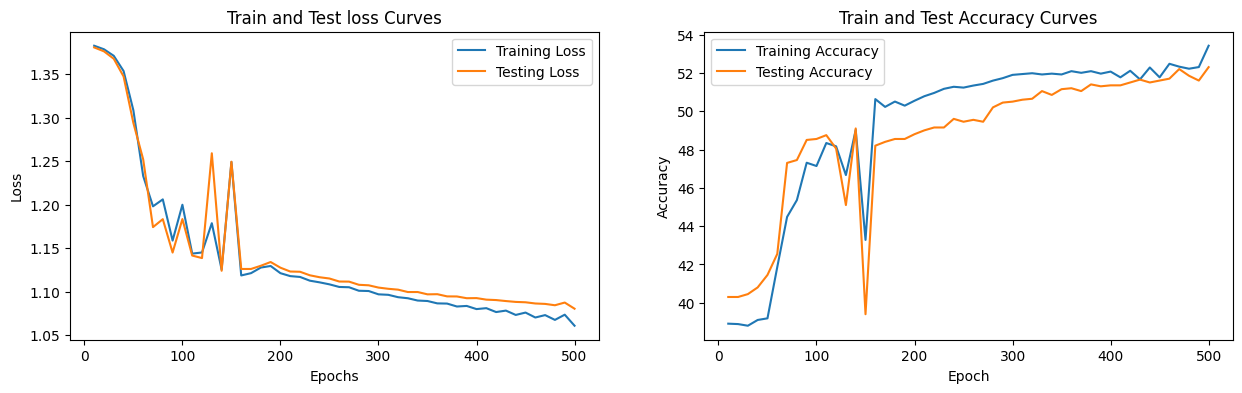

In [27]:
train_1.Plot()

In [28]:
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1.0,0.0,-1.303415,0.0,5.0,-0.478430,2.0,0.760113,3.0,0.0
2,0.0,1.0,1.420092,1.0,2.0,-0.478430,2.0,-1.207580,5.0,1.0
3,1.0,1.0,1.420092,1.0,7.0,-0.772106,1.0,-0.551682,5.0,1.0
5,1.0,1.0,0.754346,0.0,0.0,-0.772106,0.0,-0.551682,5.0,2.0
6,1.0,0.0,-0.698191,1.0,5.0,-0.478430,2.0,0.104215,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...
8062,1.0,1.0,-0.153490,1.0,0.0,-0.772106,1.0,1.416011,5.0,1.0
8064,1.0,0.0,-0.516624,0.0,4.0,0.108922,2.0,0.760113,3.0,0.0
8065,0.0,0.0,-0.637669,1.0,5.0,-0.478430,2.0,-1.207580,5.0,0.0
8066,0.0,0.0,-1.000803,1.0,5.0,-0.478430,2.0,0.760113,5.0,1.0


<Axes: xlabel='Age', ylabel='Density'>

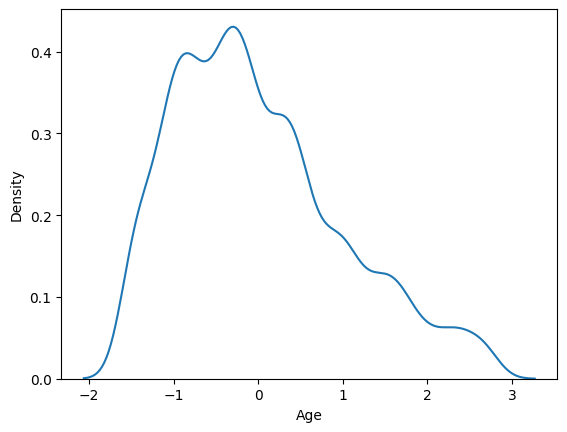

In [43]:
sns.kdeplot(df['Age'])